# Red neuronal MLP

In [1]:
# Reiniciamos todas las variables.
%reset

# Importamos las librerias necesarias.
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\HAL 9000\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1 - Importamos el dataset

### En las siguientes celdas formalizaremos los datos de entrada.

In [2]:
# Creamos el DataFrame con los datos del archivo 'GAS.MC.Entrenamiento(2005-2017).csv'.
Historico = pd.read_csv('GAS.MC.Entrenamiento(2005-2017).csv')

# Guardamos en variables los valores de la fecha(Date) y el precio de cierre de (Close).
Close = Historico['Close']
Date = Historico['Date']

# Pasamos el dataset a tipo float porque es más adecuado en el manejo de redes neuronales, aunque el dataset que usamos de
# ya está en valores de tipo float, es bueno mantener esta línea por si probasemos nuevos datasets con valores de tipo entero.
Close = Close.astype(float)

# Varible que define nuestro intervalo para estudiar predicciones (En nuestro caso tomamos el valor 20 porque es el intervalo
# entre meses de los cierres de la empresa).
periodo = 20

# Cogemos el 80 % de los datos para el entrenamiento.
NumDatosEntrenamiento = round(len(Close) * 0.8) - periodo
# Cogemos el restante del dataset
NumDatosEvaluate = round(len(Close) * 0.2) - periodo
# En ambos dataset les restamos el periodo ya que los últimos valores del dataset no tienen salida ya que son mínimamente 
# necesarios 20 valores (en nuestro caso 20 por el periodo que escogimos) para poder conocer una salida. Por ejemplo para que
# el último valor de nuestro dataset tuviera salida deberíamos conocer los siguientes 20 valores.

# Para imprimir información adicional y comprobar el funcionamiento.
print(len(Close))
print(NumDatosEntrenamiento)
print(NumDatosEvaluate)

3240
2572
628


## 2 - Conjunto de entrenamiento

### Preparación de los datos de Entradas

In [3]:
# Inicializamos la matriz. 
# Tendrá el número de filas de tamaño NumDatosEntrenamiento.
# Tendrá el número de columnas de tamaño periodo ya que nos interesa que representen un intervalo de 20 días, estos días van a 
# ser los parámetros de nuestra red que generaran una salida (el día siguiente).
matrizDatosEntrenamiento = np.zeros((NumDatosEntrenamiento, periodo))

# Inicializamos la variable aux, lo interesante de esta variable es que nos permitirá movernos por el dataset en intervalos
# de valor del periodo.
aux = 0

# Creamos nuestra matriz de datos de entrada.
# Este for sirve crear nuestra matriz de datos de entrenamiento.
# Con el primer for recorremos las filas del dataset.
for i in range (0, NumDatosEntrenamiento):
    
    # Inicializamos la variable contador que nos servirá para movernos por las columnas de la matriz.
    cont = 0
    # En este bucle nos movemos en intervalos de 20 a través del dataset.
    for j in range (0, periodo):
        
        # Guardamos los valores de los cierres en las matriz de entrenamiento.
        matrizDatosEntrenamiento[i][cont] = np.array(Close[j + aux])
        # Como podemos ver, cuando aux aumente de valor los intervalos por los que nos movemos aumentarán, es decir en nuestro
        # caso el primer intervalo es [0 - 20], el segundo será [1 - 21] y el tercero [2 - 32] y etc...
        cont = cont + 1
    
    aux = aux + 1
    
# Para explicarnos mejor lo que hacemos aqui proponemos un ejemplo.
# Imaginemos que tenemos 21 valores de cierres de una empresa.
# nuestros parámetros van a ser los valores de los veinte primeros días y la salida generada sería el valor del día 21.
# En el bucle anterior estamos creando nuestra matriz de entrenamiento en la que cada fila guarda intervalos de 20 días, es 
# decir, fila 0 guardará los datos de 0-20, fila 1 los datos de 1-21, etc... hasta terminar con todo el dataset.

# Para imprimir información adicional y comprobar el funcionamiento.
print(matrizDatosEntrenamiento)
print(matrizDatosEntrenamiento.shape)

[[19.050699 19.1103   19.1444   ... 19.1444   19.2721   19.3062  ]
 [19.1103   19.1444   19.1359   ... 19.2721   19.3062   19.493601]
 [19.1444   19.1359   19.152901 ... 19.3062   19.493601 19.3999  ]
 ...
 [22.73     22.235001 22.165001 ... 21.155001 21.105    21.225   ]
 [22.235001 22.165001 22.535    ... 21.105    21.225    21.155001]
 [22.165001 22.535    22.540001 ... 21.225    21.155001 21.73    ]]
(2572, 20)


### Preparación de los datos de Salidas

In [4]:
# Inizializamos el vector.
Salida = np.zeros(NumDatosEntrenamiento)

# Inicializamos una variable con el valor de nuestro periodo que usaremos más adelante.
aux = periodo

# En este bucle guardamos en el vector Salida los valores de Close que representan nuestra salida deseada para la matriz de 
# entrenamiento.
for i in range (0, NumDatosEntrenamiento):
    # Debemos empezar a guardar desde la posición del valor aux ya que es donde se guarda la primera salida deseada de nuestro 
    # primer ejemplo de entrenamiento.
    Salida[i] = Close[aux]
    aux = aux +1   

# Convertimos Salida a un DataFrame. Esto lo hacemos para poder usar la ventaja de las funciones de pandas como .iloc.
Salida = pd.DataFrame(Salida) 

# Con este bucle creamos nuestra matriz de salidas de entrenamiento.
for i in range(0, len(Salida)) :

    if(i == 0) :
        salidaEntrenamiento = np.array([Salida.iloc[i, :]]) 
    else :
        salida1 = np.array([Salida.iloc[i, :]])    
        salidaEntrenamiento = np.concatenate((salidaEntrenamiento, salida1), axis = 0)

# Para imprimir información adicional y comprobar el funcionamiento.
print(salidaEntrenamiento)
print(salidaEntrenamiento.shape)

[[19.493601]
 [19.3999  ]
 [19.6639  ]
 ...
 [21.155001]
 [21.73    ]
 [21.6     ]]
(2572, 1)


# 3 - Conjunto de validación

### Preparación de los datos de Entradas

In [5]:
# Realizamos el mismo proceso que la preparación de entradas del conjunto de entrenamiento pero esta vez con el conjunto de 
# evaluación.

# Inicializamos nuestra matriz con ceros de un tamaño correspondiente al resto del dataset no usado (que es el 20 % restante). 
matrizDatosEvaluate = np.zeros((NumDatosEvaluate, periodo))

# Esta variable auxiliar nos servirá para coger la salida correspondiente, en esta caso la inicializamos a la primera posición
# de nuestro dataset de evaluate que es la misma posición que nuestro número de ejemplos de entrenamiento más el periodo, le
# sumamos el periodo ya que si recordamos al principio le restamos esa cantidad porque eran datos que no servían.
aux = NumDatosEntrenamiento + periodo

# Este for sirve para crear nuestra matriz de entradas para el evaluate.
for i in range (0, NumDatosEvaluate):
    
    cont = 0
    for j in range (0, periodo):
            
        matrizDatosEvaluate[i][cont] = np.array(Close[j + aux])
        cont = cont+1
        
    aux = aux + 1
    
# Para imprimir información adicional y comprobar el funcionamiento.
print(matrizDatosEvaluate)
print(matrizDatosEvaluate.shape)

[[21.315001 21.225    21.120001 ... 20.9      21.014999 20.969999]
 [21.225    21.120001 20.559999 ... 21.014999 20.969999 20.82    ]
 [21.120001 20.559999 20.34     ... 20.969999 20.82     20.700001]
 ...
 [18.445    18.700001 18.85     ... 19.25     19.299999 19.24    ]
 [18.700001 18.85     18.780001 ... 19.299999 19.24     19.299999]
 [18.85     18.780001 18.635    ... 19.24     19.299999 19.25    ]]
(628, 20)


### Preparación de los datos Salidas

In [6]:
# Realizamos el mismo proceso que con la preparación de salidas del conjunto de entrenamiento pero esta vez con el conjunto de
# evaluación.

# Inizializamos el vector de salidas.
Salida = np.zeros(NumDatosEvaluate)

# Esta variable auxiliar nos servirá para coger la salida correspondiente, en esta caso la inicializamos a la primera posición
# de nuestro dataset de evaluate que es la misma posición que nuestro número de ejemplos de entrenamiento más el periodo y a 
# esta cantidad le sumamos otra vez el periodo. La razon por la que sumamos la primera vez el peridodo es porque si recordamos
# al principio le restamos esa cantida a NumDatosEntrenamiento porque eran datos que no servían. La segunda vez que sumamos el
# periodo es porque la salida deseada esta una cantidad (de valor periodo) por delante de nuestro primer dato de evaluación. 
# Ya que se necesita una cantidad (de valor periodo) mínima de datos de evaluación para obtener una salida.
aux = (NumDatosEntrenamiento + periodo) + periodo

# En este bucle guardamos en el vector Salida los valores de Close que representan nuestra salida deseada para la matriz de 
# evaluación.
for i in range (0, NumDatosEvaluate):

    # Debemos empezar a guardar desde la posición del valor aux ya que es donde se guarda la primera salida deseada de nuestro 
    # primer ejemplo de evaluación.
    Salida[i] = Close[aux]
    aux = aux + 1

# Convertimos Salida a un DataFrame. Esto lo hacemos para poder usar la ventaja de las funciones de pandas como .iloc.
Salida = pd.DataFrame(Salida)

# Con este bucle creamos nuestra matriz de salidas de entrenamiento.
for i in range(0, len(Salida)) :

    if(i == 0) :
        salidaValidacion = np.array([Salida.iloc[i, :]]) 
    else :
        salida2 = np.array([Salida.iloc[i, :]])    
        salidaValidacion = np.concatenate((salidaValidacion, salida2), axis = 0)

# Para imprimir información adicional y comprobar el funcionamiento.
print(salidaValidacion)
print(salidaValidacion.shape)

[[20.82    ]
 [20.700001]
 [20.549999]
 [20.365   ]
 [20.535   ]
 [20.145   ]
 [19.834999]
 [19.785   ]
 [19.84    ]
 [19.77    ]
 [20.      ]
 [20.      ]
 [20.295   ]
 [20.309999]
 [20.07    ]
 [19.844999]
 [19.93    ]
 [19.82    ]
 [19.91    ]
 [19.834999]
 [19.725   ]
 [19.639999]
 [18.945   ]
 [17.985001]
 [18.145   ]
 [17.945   ]
 [18.110001]
 [18.450001]
 [18.1     ]
 [17.815001]
 [17.73    ]
 [17.975   ]
 [17.379999]
 [17.450001]
 [17.57    ]
 [17.985001]
 [17.535   ]
 [17.195   ]
 [17.1     ]
 [17.379999]
 [18.424999]
 [18.57    ]
 [18.465   ]
 [18.135   ]
 [17.445   ]
 [17.575001]
 [17.215   ]
 [17.74    ]
 [17.35    ]
 [17.125   ]
 [17.43    ]
 [17.709999]
 [18.059999]
 [18.549999]
 [18.700001]
 [18.905001]
 [19.07    ]
 [19.5     ]
 [19.280001]
 [19.025   ]
 [19.195   ]
 [19.32    ]
 [19.34    ]
 [19.33    ]
 [19.309999]
 [19.535   ]
 [19.825001]
 [19.885   ]
 [19.985001]
 [19.684999]
 [19.834999]
 [19.625   ]
 [19.709999]
 [19.959999]
 [20.084999]
 [20.139999]
 [20.139999]

# 4 - Datos para predecir, 2018 (Hasta el 27-04)

In [7]:
# Seguiremos el mismo proceso que con la carga de dato de entrada pero en este caso el archivo que usamos es el de predicción.
# Cargamos los datos de la predicción.
DatosPrediccion = pd.read_csv('GAS.M.Prediccion(2018).csv')

ClosePrediccion = DatosPrediccion['Close']
ClosePrediccion = ClosePrediccion.astype(float)

NumDatosPrediccion = len(ClosePrediccion) - periodo

# Inicializamos la matriz.
matrizDatosPrediccion = np.zeros((NumDatosPrediccion, periodo))

aux=0

# Guardamos los datos en la matriz.
for i in range (0, NumDatosPrediccion):
    
    cont=0
    for j in range (0, periodo):
            
        matrizDatosPrediccion[i][cont] = np.array(ClosePrediccion[j + aux])
        cont = cont+1
        
    aux = aux + 1

# Para imprimir información adicional y comprobar el funcionamiento.
print(matrizDatosPrediccion)
print(matrizDatosPrediccion.shape)

[[19.92     20.290001 20.73     ... 19.549999 19.290001 18.965   ]
 [20.290001 20.73     20.76     ... 19.290001 18.965    18.475   ]
 [20.73     20.76     20.709999 ... 18.965    18.475    18.605   ]
 ...
 [18.83     19.1      19.67     ... 20.67     20.379999 20.719999]
 [19.1      19.67     19.389999 ... 20.379999 20.719999 20.709999]
 [19.67     19.389999 19.48     ... 20.719999 20.709999 20.889999]]
(62, 20)


# 4 - Construimos la red neuronal

In [8]:
model = Sequential()

model.add(Dense(200, input_dim = periodo, activation = 'relu'))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(matrizDatosEntrenamiento, salidaEntrenamiento, epochs = 200)

# Guardamos el modelo.
model.save('MLP.h5')

Epoch 1/200
2572/2572 [==============================] - 1s 217us/step - loss: 17.0010
Epoch 2/200
2572/2572 [==============================] - 0s 49us/step - loss: 0.5724
Epoch 3/200
2572/2572 [==============================] - 0s 50us/step - loss: 0.5426
Epoch 4/200
2572/2572 [==============================] - 0s 49us/step - loss: 0.5224
Epoch 5/200
2572/2572 [==============================] - 0s 49us/step - loss: 0.4891
Epoch 6/200
2572/2572 [==============================] - 0s 47us/step - loss: 0.4612
Epoch 7/200
2572/2572 [==============================] - 0s 54us/step - loss: 0.4843
Epoch 8/200
2572/2572 [==============================] - 0s 52us/step - loss: 0.4931
Epoch 9/200
2572/2572 [==============================] - 0s 50us/step - loss: 0.4081
Epoch 10/200
2572/2572 [==============================] - 0s 47us/step - loss: 0.3926
Epoch 11/200
2572/2572 [==============================] - 0s 49us/step - loss: 0.3855
Epoch 12/200
2572/2572 [==============================] - 0s 

2572/2572 [==============================] - 0s 38us/step - loss: 0.2213
Epoch 97/200
2572/2572 [==============================] - 0s 36us/step - loss: 0.1735
Epoch 98/200
2572/2572 [==============================] - 0s 43us/step - loss: 0.1812
Epoch 99/200
2572/2572 [==============================] - 0s 43us/step - loss: 0.1687
Epoch 100/200
2572/2572 [==============================] - 0s 39us/step - loss: 0.1614
Epoch 101/200
2572/2572 [==============================] - 0s 47us/step - loss: 0.2509
Epoch 102/200
2572/2572 [==============================] - 0s 37us/step - loss: 0.2299
Epoch 103/200
2572/2572 [==============================] - 0s 39us/step - loss: 0.1770
Epoch 104/200
2572/2572 [==============================] - 0s 53us/step - loss: 0.1682
Epoch 105/200
2572/2572 [==============================] - 0s 53us/step - loss: 0.2308
Epoch 106/200
2572/2572 [==============================] - 0s 52us/step - loss: 0.1768
Epoch 107/200
2572/2572 [==============================] - 0

2572/2572 [==============================] - 0s 36us/step - loss: 0.1635
Epoch 191/200
2572/2572 [==============================] - 0s 38us/step - loss: 0.1583
Epoch 192/200
2572/2572 [==============================] - 0s 43us/step - loss: 0.1970
Epoch 193/200
2572/2572 [==============================] - 0s 43us/step - loss: 0.1905
Epoch 194/200
2572/2572 [==============================] - 0s 44us/step - loss: 0.1674
Epoch 195/200
2572/2572 [==============================] - 0s 58us/step - loss: 0.1416
Epoch 196/200
2572/2572 [==============================] - 0s 47us/step - loss: 0.1515
Epoch 197/200
2572/2572 [==============================] - 0s 45us/step - loss: 0.1672
Epoch 198/200
2572/2572 [==============================] - 0s 68us/step - loss: 0.1532
Epoch 199/200
2572/2572 [==============================] - 0s 76us/step - loss: 0.1417
Epoch 200/200
2572/2572 [==============================] - 0s 58us/step - loss: 0.1674


### Evaluamos nuestro modelo

In [9]:
# Cargamos aqui el modelo, esto será util en el caso de no querer entrenar de nuevo nuestro modelo.
model = load_model('MLP.h5')

validacion = model.evaluate(matrizDatosEvaluate, salidaValidacion)


628/628 [==============================] - 0s 68us/step


# 5 - Dibujamos una representación del modelo y la gráfica del error

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4200      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 4,401
Trainable params: 4,401
Non-trainable params: 0
_________________________________________________________________


### Pintamos la gráfica del error para el conjunto entrenamiento

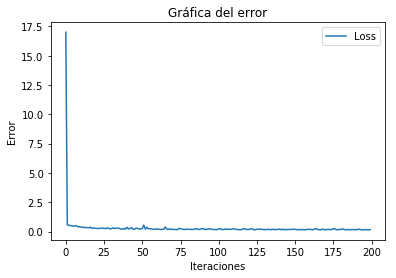

In [11]:
plt.plot(history.history['loss'])
plt.title('Gráfica del error')
plt.ylabel('Error')
plt.xlabel('Iteraciones')
plt.legend(['Loss'], loc='upper right')
plt.show()

# 6 - Prueba de predicción

In [12]:
predicion = model.predict(matrizDatosPrediccion)

# 7 - Calculamos el valor de los pesos de cada parámetro de nuestro dataset

In [13]:
for i in range(0, periodo):
    print("Para la entrada", i, "la suma de sus pesos es:", sum((model.get_weights()[0][i]) **2))

Para la entrada 0 la suma de sus pesos es: 1.7679686293290615
Para la entrada 1 la suma de sus pesos es: 1.773688072264747
Para la entrada 2 la suma de sus pesos es: 1.617837367887205
Para la entrada 3 la suma de sus pesos es: 1.9094400674716994
Para la entrada 4 la suma de sus pesos es: 1.88729264931726
Para la entrada 5 la suma de sus pesos es: 1.806558918145754
Para la entrada 6 la suma de sus pesos es: 1.890709888538936
Para la entrada 7 la suma de sus pesos es: 1.779494851460612
Para la entrada 8 la suma de sus pesos es: 1.803606545528055
Para la entrada 9 la suma de sus pesos es: 1.8396600270348813
Para la entrada 10 la suma de sus pesos es: 1.8019612737879953
Para la entrada 11 la suma de sus pesos es: 1.9046447386826912
Para la entrada 12 la suma de sus pesos es: 1.6466822266149848
Para la entrada 13 la suma de sus pesos es: 2.03418359945681
Para la entrada 14 la suma de sus pesos es: 1.831221849232757
Para la entrada 15 la suma de sus pesos es: 1.9150989939912506
Para la entra

# 8 - Dibujamos la grafica de todo el histórico de datos (2005-2017)

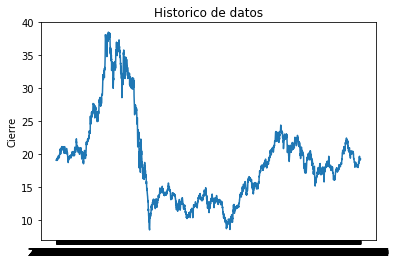

In [15]:
# Cargamos los datos.
Datos = pd.read_csv('GAS.MC.Entrenamiento(2005-2017).csv')

valores = Datos['Close']
dias = Datos['Date']

plt.clf()
plt.plot(dias,valores)

plt.ylabel('Cierre')
plt.title('Historico de datos')
plt.show()

# 9 - Dibujamos la gráfica del histórico de datos (2018) para comprobar que la predicción es correcta

### Estos datos son extraidos del dataset. No se han utilizado ni para el entrenamiento ni la validación.

82
[18.475    18.605    19.09     18.825001 18.344999 17.690001 17.91
 17.91     18.025    18.51     18.530001 18.485001 18.309999 18.445
 18.325001 18.34     18.280001 18.615    19.014999 19.15     19.1
 18.815001 18.58     18.295    18.615    18.49     18.565001 18.555
 18.709999 19.       19.030001 18.82     18.775    18.834999 18.91
 18.889999 18.82     18.83     18.700001 18.83     19.1      19.67
 19.389999 19.48     19.48     19.690001 19.67     19.77     19.75
 19.950001 19.885    20.049999 20.120001 20.15     20.23     20.32
 20.67     20.379999 20.719999 20.709999 20.889999 20.959999]


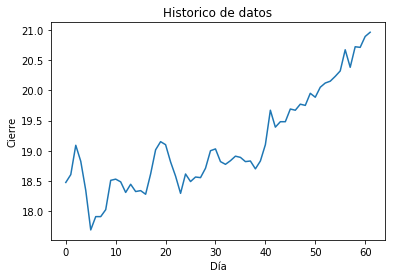

In [16]:
# Cargamos los datos.
Datos = pd.read_csv('GAS.M.Prediccion(2018).csv')

valores = Datos['Close']
dias = Datos['Date']
print(len(valores))
plt.plot(dias,valores)

#Bucle para la salida
cont = 0
Dias = len(valores) - periodo
NumDia = np.zeros((len(valores) - periodo))
SalidaGrafica = np.zeros((Dias))

for x in range (periodo, len(valores)):
    SalidaGrafica[cont] = valores[x]
    cont = cont + 1
    
print(SalidaGrafica)

for i in range(0, len(SalidaGrafica)):
    NumDia[i] = i
    
plt.clf()
plt.plot(NumDia, SalidaGrafica)
plt.xlabel('Día')
plt.ylabel('Cierre')
plt.title('Historico de datos')
plt.show()

# 10 - Dibujamos la gráfica de los datos que se han predicho

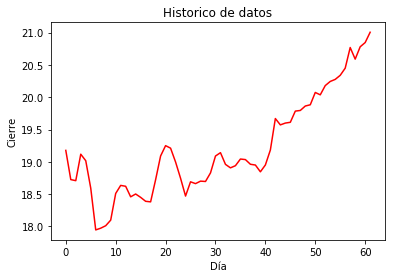

In [17]:
NumeroDias = len(valores) - periodo
DiasPrediccion = np.zeros(len(valores) - periodo)

#Nombramos los días con números
for x in range  (0, NumeroDias):
        DiasPrediccion[x] = x 

plt.clf()
plt.plot(DiasPrediccion, predicion, 'r')
plt.xlabel('Día')
plt.ylabel('Cierre')
plt.title('Historico de datos')
plt.show()

# 9 - Dibujamos las dos gráficas juntas

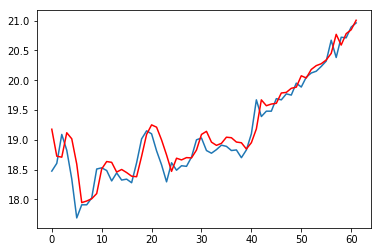

In [18]:
plt.clf()

# Salida real de la gráfica en azul.
plt.plot(SalidaGrafica)

# Salida predicha en rojo.
plt.plot(predicion,'r')
plt.show()